# Advanced Seminar Code

## Table of Contents

0. Initial Setup
1. Data Generation
2. Matching Availability of Patient and Bed
3. Class Generation for Each Patient and Bed
4. Class Generation to Confirm Schedules with First-Come-First-Serve (FCFS) and Multi-Appointment Scheduling
5. First-Class-First-Serve Approach to Confirm Schedules
6. Getting the Results of FCFS

## 0. Initial Setup

In [211]:
# Import standard packages
import copy
import csv
from datetime import datetime
import math
from math import e
import matplotlib.pyplot as plt
import random
import time

In [212]:
# import third-party packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [213]:
# import local library imports
from calculate_value import *
from data_generation import *
from matched_availability import *
from schedule_appointment import * 

## 1. Data Generation

Each instance is characterized by three parameters ( r, κ, δ), where r is patient to bed ratio, κ is the number of slots per hour (larger κresults in shorter time slots and therefore patients will have more flexibility in selecting their available/target times), and finally, δ is the maximum allowable deviation from patient target times (presented in the number of slots). We generate m =   r ∗ n   instances, where n is the number of available beds and m is the number of patients.

Similar to a typical hemodialysis center, we consider 14 hours per day and 6 days per week (8:00 AM to 10:00 PM; Monday–Saturday). Patient available times for each day are generated independently. We split each day into two parts: morning and evening. Slots in each part of the day have an equal chance to be selected by patients (50% chance). More precisely, each day is composed of 14 ∗δslots. If a patient is available in the morning of a specific day (with 50% chance), then their ideal time slot is a random slot selected from { 1 , 2 , . . . , (14 ∗ κ) / 2 } . Likewise, if the patient is avail- able in the evening, his ideal time slot is randomly selected from { ((14 ∗ κ) / 2 ) + 1 , ((14 ∗ κ) / 2) + 2 , . . . , 14 ∗κ} . In case the selected evening slot doesn’t allow for a feasible dialysis appointment, a new slot is ran- domly selected. Note that it is possible that a patient is available in both parts of the day (with a 25% chance), i.e., the patient has two ideal time slots. In this case one appointment can be sched- uled in either of the slots (please note the one-day time separation between patient’s consecutive appointments). Dialysis treatment times are 4 hours, to comply with the average reported length of hemodialysis treatment. 6 We randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w k j weight in the objec- tive function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In the United States, a typical hemodialysis center, includ- ing our collaborating hemodialysis center, has approximately four hemodialysis patients per bed per day ( System, 2013 ). Consider- ing the expected growth in the demand for dialysis ( Medicare Pay- ment Advisory Commission, 2021 ), we evaluate the performance of our proposed BP algorithms for two patient-to-bed ratios of 4 and 5. For each patient-to-bed ratio, we consider time slot settings of 1 slot per hour and 2 slots per hour (half-hour slots). For each ratio-slot combination, we consider three maximum allowable de- viations from target times of 1 slot, 2 slots, and 4 slots. In terms of bed-patient size, the smallest instance starts with 10 beds and 40 patients, and the largest size represents a hemodialysis center with 20 beds and 100 patients. For every configuration in our test data set, we randomly generate 5 instances, resulting in a total of 270 instances, and report the average of 5 instances and the worst case for each configuration. 7

### 1a. Define some initial variables

I define some initial variables for to set, that can be changed and generate different outcomes. 

#### 1ai. Variables that can be changed to create different graphs. 

Combinations of  (n,m,δ) when patient to bed ratio = 4: ['10-40-1',	'15-60-1',	'20-80-1',	'10-40-2',	'15-60-2',	'20-80-2',	'10-40-4',	'15-60-4',	'20-80-4']


Combinations of  (n,m,δ) when patient to bed ratio = 5: ['10-50-1',	'15-75-1',	'20-100-1',	'10-50-2',	'15-75-2',	'20-100-2',	'10-50-4',	'15-75-4',	'20-100-4']

In [284]:
## DECISION VARIABLES
# n = number of available beds
num_beds = 15
# m = number of patients
num_patients = 60

## VARIABLE RELATED TO THE DEVIATION 
# δ = maximum allowed deviation from patient target times based on number of slots
max_allowed_deviation = 1

### 1aii. Variables that may be possible to change though with limited functionality

The variabels below can be changed from the default, though I did not thoroughly test them so I cannot guarantee if the code will work if these variables are changed. 

In [285]:
## VARIABLES RELATED TO TIME
# κ = number of slots per hour , should not be over than 4! This is recommended from paper of Reihaneh et al.
num_of_slots_per_hour = 1
# Based on pg 37 of Rehihnahe et al. this is usually 3 required dialysis essions
num_required_dialysis_sessions = 3
# number of days per week
num_days_per_week = 6
# each day is composed of 14 hours per day ∗ δ slots
num_slots_per_day = 14 * num_of_slots_per_hour

### 1b. Define an empty list containing all available time slots

Reihaneh et al.: For example, assuming 8 AM as the earliest availability of beds for K = 1, dialysis can only be scheduled at {8, 9, 10,..,} whereas for k = 4, dialysis may begin at {8, 8:15, 8:30, 9:00, 9:15, .. }. In this paper we consider K 
tion of time (i.e., .> 4 ) causes an exponential increase in solution
space, which is not justified as the average dialysis appointment
usually lasts 4 hours, and 5–10 minutes deviation does not affect
the show-up probability of patients.

In [286]:
# define a the list of open time slots based on the num of slots per hour. 
available_time_slot_list = []

Create a list of open time slots that will be used to create the schedule for the patients. As an example, the resulting open time slot list 
will be something like [830, 900, 930,..] assuming that there are 2 slots per hour, and 14 working hours per day. We assume that the possible 
maximum number of slots per hour is only 4 based on the approach of Reihaneh et al.

In [287]:
available_time_slot_list = generate_available_time_slots(num_slots_per_day, num_of_slots_per_hour)

In [288]:
available_time_slot_list

[800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200]

### 1c. Define a list of random-generated priorities and assigned to the patients

This concept is based on Reihaneh et al.'s: I randomly generate three different priority weights for patients. Every patient jhas ζk chance of having priority k ∈ { 1 , 2 , 3 } , thus, receiving a w_j^k weight in the objective function. We consider ζ1 = 0 . 6 , w 1 = 1 ; ζ2 = 0 . 25 , w 2 = 1 . 4 ; and ζ3 = 0 . 15 , w 3 = 2 .

In [289]:
# Define the priority that the patient should be assigned and the probability of the patient getting them
priority = [1,2,3]
probabilities = [0.6, 0.25, 0.15]

In [290]:
random_priority = []
random_priority = generate_patient_random_priority(num_patients, priority, probabilities)

In [291]:
# Each item in the list represents a single patient, with the first one being patient 1 with index 0 in the list
random_priority

[2,
 1,
 3,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 2]

### 1d. Define the prescribed dialysis hours

In [292]:
prescribed_dialysis_hours_list = []
prescribed_dialysis_hours_list = generate_prescribed_dialysis_hours(num_patients)

In [293]:
prescribed_dialysis_hours_list

[15,
 12,
 15,
 9,
 12,
 12,
 15,
 9,
 12,
 15,
 15,
 15,
 15,
 9,
 12,
 9,
 12,
 9,
 15,
 9,
 15,
 9,
 9,
 15,
 12,
 12,
 12,
 9,
 12,
 9,
 12,
 12,
 9,
 15,
 12,
 15,
 9,
 15,
 12,
 12,
 9,
 12,
 9,
 9,
 12,
 12,
 12,
 15,
 15,
 15,
 12,
 9,
 9,
 9,
 12,
 12,
 9,
 9,
 12,
 12]

### 1e. Create functions to set up a randomized dictionary to assign the availability of the patient and bed

Each patient will have an name, ideal schedule, priority, and weight

#### 1ei. Function to create the initial empty dict with available time slots for the patient and bed

if num of slots per hour == 1:
   then append all the hours to 00
if num of slots per hour > 1:


In [294]:
# Give higher preference to giving availability so generating 1
not_available = 0
available = 1

probabilities_availability = [0.8, 0.2]

random_number = random.choices([available, not_available], probabilities_availability)[0]

In [295]:
# Put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# All_patients_availability_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_beds_availablity_list = []

# Append the patient profiles into the list
for bed in range(0, num_beds):
    all_beds_availablity_list.append(create_bed_profile(bed, available_time_slot_list))

In [296]:
all_beds_availablity_list

[{'bed': 'b1',
  'bed_availability': {1: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   2: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   4: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   5: {800: 0,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    210

#### 1eii. Create dictionary profile for the patient

In [297]:
# put the patient profiles in a list to grab them more easily so here I initiate an empty patient list
# patients_list is a list of patient profile dictionaries. The ideal_schedule is also a dictionary
all_patients_availability_list = []

# append the patient profiles into the list
for patient in range(0, num_patients):
    print(patient)
    all_patients_availability_list.append(create_patient_profile(patient, available_time_slot_list, random_priority, prescribed_dialysis_hours_list))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [298]:
all_patients_availability_list

[{'patient': 'p1',
  'priority': 2,
  'weight': 1.4,
  'prescribed_dialysis_hours': 15,
  'patient_availability': {1: {800: 0,
    900: 1,
    1000: 0,
    1100: 1,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1600: 1,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0,
    2100: 1,
    2200: 1},
   2: {800: 0,
    900: 0,
    1000: 1,
    1100: 1,
    1200: 0,
    1300: 1,
    1400: 1,
    1500: 0,
    1600: 1,
    1700: 0,
    1800: 1,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {800: 1,
    900: 0,
    1000: 0,
    1100: 0,
    1200: 1,
    1300: 1,
    1400: 1,
    1500: 0,
    1600: 0,
    1700: 1,
    1800: 0,
    1900: 1,
    2000: 1,
    2100: 0,
    2200: 1},
   4: {800: 0,
    900: 1,
    1000: 1,
    1100: 1,
    1200: 1,
    1300: 1,
    1400: 1,
    1500: 1,
    1600: 1,
    1700: 1,
    1800: 1,
    1900: 1,
    2000: 0,
    2100: 0,
    2200: 0},
   5: {800: 0,
    900: 0,
    1000: 1,
    1100: 0,
    1200: 0,
    1300: 1,
    1400: 1,
    1500

## 2. Matching Availability of Patient and Bed

### 2a. Create dictionary of where the availabilities of the bed and patient match

In [299]:
# define a list of cases when the availablity of the patient and bed match
all_patients_matched_availability = match_bed_patient_availability(all_patients_availability_list, all_beds_availablity_list)

# Print the updated all_patients_matched_availability
for entry in all_patients_matched_availability:
    print(entry)


p1
day  1
day  2
day  3
day  4
day  5
day  6
p2
day  1
day  2
day  3
day  4
day  5
day  6
p3
day  1
day  2
day  3
day  4
day  5
day  6
p4
day  1
day  2
day  3
day  4
day  5
day  6
p5
day  1
day  2
day  3
day  4
day  5
day  6
p6
day  1
day  2
day  3
day  4
day  5
day  6
p7
day  1
day  2
day  3
day  4
day  5
day  6
p8
day  1
day  2
day  3
day  4
day  5
day  6
p9
day  1
day  2
day  3
day  4
day  5
day  6
p10
day  1
day  2
day  3
day  4
day  5
day  6
p11
day  1
day  2
day  3
day  4
day  5
day  6
p12
day  1
day  2
day  3
day  4
day  5
day  6
p13
day  1
day  2
day  3
day  4
day  5
day  6
p14
day  1
day  2
day  3
day  4
day  5
day  6
p15
day  1
day  2
day  3
day  4
day  5
day  6
p16
day  1
day  2
day  3
day  4
day  5
day  6
p17
day  1
day  2
day  3
day  4
day  5
day  6
p18
day  1
day  2
day  3
day  4
day  5
day  6
p19
day  1
day  2
day  3
day  4
day  5
day  6
p20
day  1
day  2
day  3
day  4
day  5
day  6
p21
day  1
day  2
day  3
day  4
day  5
day  6
p22
day  1
day  2
day  3
day  4
day  5
day 

#### 2ai. Consolidate the list together to get a combination of patients and beds

In [300]:
patients_beds_combo_consolidated_dict = get_combination_patients_beds(all_patients_matched_availability)

# Print the consolidated dictionary
for entry in patients_beds_combo_consolidated_dict.values():
    print(entry)


{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b3',

In [301]:
all_patients_matched_availability

[{'patient': 'p1',
  'bed': 'b1',
  'matched_availability': {1: {800: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {800: 0,
    900: 0,
    1200: 0,
    1500: 0,
    1700: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0},
   4: {800: 0, 2000: 0, 2100: 0, 2200: 0},
   5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0},
   6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'matched_availability': {1: {800: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {800: 0,
    900: 0,
    1200: 0,
    1500: 0,
    1700: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0},
   4: {800: 0, 2000: 0, 2100: 0, 2200: 0},
   

In [302]:
patients_beds_combo_consolidated_dict

{'b1-p1': {'patient': 'p1',
  'bed': 'b1',
  'matched_availability': {1: {800: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {800: 0,
    900: 0,
    1200: 0,
    1500: 0,
    1700: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0},
   4: {800: 0, 2000: 0, 2100: 0, 2200: 0},
   5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0},
   6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}},
 'b2-p1': {'patient': 'p1',
  'bed': 'b2',
  'matched_availability': {1: {800: 0,
    1000: 0,
    1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {800: 0,
    900: 0,
    1200: 0,
    1500: 0,
    1700: 0,
    1900: 0,
    2000: 0,
    2100: 0,
    2200: 0},
   3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0},
   4: {800: 0, 2000: 0, 2100

### 2b. Create function to allocate POSSIBLE single appointment schedules based on the 3 - 5 consecutive values of 0 (which indicates availability) of the matched availability

Create all_patient_schedules list to see a list of all patients and their possible allocated schedules based on the consecutive availabilities

In [303]:
for key in all_patients_matched_availability:
    print(key)

{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b2', 'matched_availability': {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}}
{'patient': 'p1', 'bed': 'b3',


{'patient': 'p14', 'bed': 'b9', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b10', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b11', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b12', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b13', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b14', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b15', 'matched_availability': {4: {900: 0, 1000: 0, 1500: 0, 1600: 0, 1700: 0, 1900: 0, 2200: 0}}}
{'patient': 'p14', 'bed': 'b1', 'matched_availability': {5: {1000: 0, 1300: 0, 1700: 0, 1800: 0, 2000: 0}}}
{'patient'

In [304]:
patient_bed_keys = list(patients_beds_combo_consolidated_dict.keys())

In [305]:
patient_bed_keys

['b1-p1',
 'b2-p1',
 'b3-p1',
 'b4-p1',
 'b5-p1',
 'b6-p1',
 'b7-p1',
 'b8-p1',
 'b9-p1',
 'b10-p1',
 'b11-p1',
 'b12-p1',
 'b13-p1',
 'b14-p1',
 'b15-p1',
 'b1-p2',
 'b2-p2',
 'b3-p2',
 'b4-p2',
 'b5-p2',
 'b6-p2',
 'b7-p2',
 'b8-p2',
 'b9-p2',
 'b10-p2',
 'b11-p2',
 'b12-p2',
 'b13-p2',
 'b14-p2',
 'b15-p2',
 'b1-p3',
 'b2-p3',
 'b3-p3',
 'b4-p3',
 'b5-p3',
 'b6-p3',
 'b7-p3',
 'b8-p3',
 'b9-p3',
 'b10-p3',
 'b11-p3',
 'b12-p3',
 'b13-p3',
 'b14-p3',
 'b15-p3',
 'b1-p4',
 'b2-p4',
 'b3-p4',
 'b4-p4',
 'b5-p4',
 'b6-p4',
 'b7-p4',
 'b8-p4',
 'b9-p4',
 'b10-p4',
 'b11-p4',
 'b12-p4',
 'b13-p4',
 'b14-p4',
 'b15-p4',
 'b1-p5',
 'b2-p5',
 'b3-p5',
 'b4-p5',
 'b5-p5',
 'b6-p5',
 'b7-p5',
 'b8-p5',
 'b9-p5',
 'b10-p5',
 'b11-p5',
 'b12-p5',
 'b13-p5',
 'b14-p5',
 'b15-p5',
 'b1-p6',
 'b2-p6',
 'b3-p6',
 'b4-p6',
 'b5-p6',
 'b6-p6',
 'b7-p6',
 'b8-p6',
 'b9-p6',
 'b10-p6',
 'b11-p6',
 'b12-p6',
 'b13-p6',
 'b14-p6',
 'b15-p6',
 'b1-p7',
 'b2-p7',
 'b3-p7',
 'b4-p7',
 'b5-p7',
 'b6-p7',
 'b7

In [306]:
all_possible_patient_schedules = []

In [307]:
for key, entry in patients_beds_combo_consolidated_dict.items():
    print(entry)
    
    allocated_schedule_entry_single_patient_dict = {}
    empty_dict = {}
    print("This is the single patient matched availability:", entry['matched_availability'])
    print("This is the patient number:", entry['patient'])
    print("This is the bed number:", entry['bed'])
    #print(entry['matched_availability'])
    consecutive_zeroes_dict = allocate_single_appointment_schedule(entry['matched_availability'])
    
    print("this is the consecutive_zeroes_dict")
    print(consecutive_zeroes_dict)

    # if you get back something with a dictionary of consecutive availability:
    if len(consecutive_zeroes_dict) > 0:
        allocated_schedule_entry_single_patient_dict['patient'] = entry['patient']
        allocated_schedule_entry_single_patient_dict['bed'] = entry['bed']
        allocated_schedule_entry_single_patient_dict['possible_allocated_schedule'] = consecutive_zeroes_dict 
        all_possible_patient_schedules.append(allocated_schedule_entry_single_patient_dict)
        print(" this is the dictionary i added")
        print(allocated_schedule_entry_single_patient_dict)
    # if not, then go to the next patient
    else:
        continue
        

{'patient': 'p1', 'bed': 'b1', 'matched_availability': {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}}
This is the single patient matched availability: {1: {800: 0, 1000: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}, 2: {800: 0, 900: 0, 1200: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {900: 0, 1000: 0, 1100: 0, 1500: 0, 1600: 0, 1800: 0, 2100: 0}, 4: {800: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1100: 0, 1200: 0, 1700: 0, 1800: 0, 2000: 0, 2100: 0}, 6: {1000: 0, 1100: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 2100: 0}}
This is the patient number: p1
This i


This is the bed number: b1
{2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0}, 3: {1300: 0, 1400: 0, 1500: 0}, 5: {1500: 0, 1600: 0, 1700: 0, 1800: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1200: 0}}
this is the consecutive_zeroes_dict
{2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0}, 3: {1300: 0, 1400: 0, 1500: 0}, 5: {1500: 0, 1600: 0, 1700: 0, 1800: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1200: 0}}
 this is the dictionary i added
{'patient': 'p21', 'bed': 'b1', 'possible_allocated_schedule': {2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0}, 3: {1300: 0, 1400: 0, 1500: 0}, 5: {1500: 0, 1600: 0, 1700: 0, 1800: 0}, 6: {900: 0, 1000: 0, 1100: 0, 1200: 0}}}
{'patient': 'p21', 'bed': 'b2', 'matched_availability': {1: {900: 0, 1000: 0, 1300: 0, 1400: 0, 2000: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1400: 0, 1500: 0, 2000: 0, 2100: 0}, 3: {1000: 0, 1300: 0, 1400: 0, 1500: 0, 1700: 0, 1900: 0, 2000: 0, 2200: 0}, 4: {800: 0, 1000: 0, 1200: 0, 1400: 0, 1500: 0, 1700: 0, 1800: 0}, 5: {1500: 0

In [308]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b3',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b4

## 3. Class Generation for each patient and bed

The schedules of each patient and bed will then be a separate thing based on FCFS and 

Data structures to use from before to create classes of beds and patients
1. all_beds_availability_list = dictionary of availability of beds
2. all_patients_availability_list = dictionary of availabilty of patients
2. all_possible_patient_schedules = list of possible allocations of a patient to a certain bed

### 3a. Create class templates for patient and bed

classes.py defines the classees for the patient and bed that can be called

In [309]:
# define a class to generate set of m patient objects
class Patient: 
    def __init__(self, patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover):
        self.patient_id = patient_id
        # Total dialysis hours prescribed for j
        self.prescribed_total_dialysis_hours = prescribed_total_dialysis_hours 
        # processing time: the patient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), 
        # dialysis time on the dialysis machine, and take-offtime (a technician takes the patient off the bed, disconnects them from the dialysis machine and cleans the bed).
        self.processing_time = processing_time 
        # ideal time slots for starting dialysis sessions
        self.ideal_schedule = ideal_schedule
        # set of feasible time slots for j
        self.confirmed_schedule = confirmed_schedule
        # weight of patient j in objective function
        self.weight = weight 
        # Number of leftover appointments of j
        self.leftover = leftover 
        
    def __str__(self):
        return f"{self.patient_id}"  # for debug mode
    
    def add_confirmed_schedule(confirmed_schedule):
        self.confirmed_schedule.append(confirmed_schedule)
        
    def calculate_schedule_length(self):
        return len(self.confirmed_schedule)

In [310]:
# define a class to generate set of n identical bed objects
class Bed:
    def __init__(self, bed_id, bed_schedule):
        self.bed_id = bed_id
        self.bed_schedule = bed_schedule
    
    def __str__(self):
        return f"{self.bed_id}"  # for debug mode
 

### 3b. Instantiate object list for patient and bed

#### 3bi. Instantiate object list for the patient

In [311]:
patient_objects_list = []

for item in all_patients_availability_list:
    patient_id = item['patient']
    ideal_schedule = item['patient_availability']
    weight = item['weight']
    priority = item['priority']
    prescribed_total_dialysis_hours = item['prescribed_dialysis_hours']
    processing_time = 0
    confirmed_schedule = {}
    leftover = 0
    patient_objects_list.append(Patient(patient_id, prescribed_total_dialysis_hours, processing_time, ideal_schedule, confirmed_schedule, weight, leftover))

In [312]:
for obj in patient_objects_list:
    print(obj.patient_id)
    print(obj.calculate_schedule_length())

p1
0
p2
0
p3
0
p4
0
p5
0
p6
0
p7
0
p8
0
p9
0
p10
0
p11
0
p12
0
p13
0
p14
0
p15
0
p16
0
p17
0
p18
0
p19
0
p20
0
p21
0
p22
0
p23
0
p24
0
p25
0
p26
0
p27
0
p28
0
p29
0
p30
0
p31
0
p32
0
p33
0
p34
0
p35
0
p36
0
p37
0
p38
0
p39
0
p40
0
p41
0
p42
0
p43
0
p44
0
p45
0
p46
0
p47
0
p48
0
p49
0
p50
0
p51
0
p52
0
p53
0
p54
0
p55
0
p56
0
p57
0
p58
0
p59
0
p60
0


#### Copy the initial patient object list for later use in the simulated annealing use case

In [313]:
SA_patient_objects_list = list(patient_objects_list)

#### 3bii. Instantiate object list for the bed

In [314]:
bed_objects_list = []

for item in all_beds_availablity_list:
    bed_id = item['bed']
    bed_schedule = item['bed_availability']
    print(bed_id)
    print(bed_schedule)
    bed_objects_list.append(Bed(bed_id, bed_schedule))

b1
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 3: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 4: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 5: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 6: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}}
b2
{1: {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}, 2: {800: 0, 900: 0, 1000: 

In [315]:
for obj in bed_objects_list:
    print(obj.bed_id)

b1
b2
b3
b4
b5
b6
b7
b8
b9
b10
b11
b12
b13
b14
b15


#### Copy the initial bed object list for later use in the simulated annealing use case

In [316]:
SA_bed_objects_list = list(bed_objects_list)

## 4. First-Come-First-Serve Approach to Confirm Schedules

"In the current scheduling policy, patients are scheduled one at a time and based on the order that they are introduced to the center on a First-Come-First-Serve (FCFS) basis. To respect the one- day separation constraint, patients are only scheduled on either odd or even days. Although schedules that use both odd and even days are also feasible, it was our observation that allowing for such schedules only worsens the schedules obtained using the FCFS policy. 

We implement this FCFS policy as follows. 

For each patient j, we select schedule a ∈ j with minimum ψ a that is feasible with respect to the above constraints and can also be feasibly assigned to a bed (i.e., has no overlap with slots occupied by patients { 1 , . . . , j −1 } ). 

Recall that  j only contains schedules that are within δslot deviations from patient j’s ideal time slots. There- fore, the number of appointments in selected schedule a , may be less that the prescribed appointments for j. 

In that case, the leftover appointments, if any, are scheduled in one of the remaining feasible time slots. Figures 3 and 4 demonstrate the quality of schedules when em- ploying the FCFS policy as compared to the optimal schedules ob- tained by our proposed Enhanced CG-embedded BP algorithm, in terms of the percentage of leftover appointments (i.e.,  L ) and the hours of deviations per patient (i.e.,  D ). 

The optimal policy consistently produces schedules that outperform the FCFS policy in terms of the leftover appointments (average improvement of 98%) and the average deviation (average improvement of 46%). However, we observed that in some cases, the optimal policy returns sched- ules with higher appointment deviations (  D ), in order to find schedules that result in considerably lower leftover appointments. This is one of the major oversights that would be inevitable us- ing the FCFS policy. Tables A.5 and A.6 report the detailed results on the performance of the optimal policy developed using the En- hanced CG-embedded algorithm compared to the FCFS policy."

In [317]:
class FCFS_confirmed_schedule:
    def __init__(self, patient_schedules_in, patient_schedules_out, objective, contribution, penalty):
        # patient schedules that work out are stored inside
        self.patient_schedules_in = patient_schedules_in
        # patient schedules that did not work out get stored outside
        self.patient_schedules_out = patient_schedules_out
        # objective function value to minimize
        self.objective = objective
        # contribution of a_j to the value of the objective function 
        self.contribution = contribution
        # dual value associated with Constraint 2c TODO: IS THIS NEEDED? Constraint (2c) 
        # restricts the number of available beds to n .
        # self.lambda_dual = lambda_dual
        # penalty
        self.penalty = penalty 
    
    
    ## NOT NEEDED?
    def copy_FCFS_confirmed_schedule(self):
        new_FCFS_confirmed_schedule = FCFS_confirmed_schedule()
        new_patient_id = copy.deepcopy(patient_id)
        new_patient_schedules_in = copy.deepcopy(self.patient_schedules_in)
        new_patient_schedules_out = copy.deepcopy(self.patient_schedules_out)
        new_allocation_objective = self.objective
        new_allocation_contribution = self.contribution
        # new_lambda_dual = self.lambda_dual
        new_penalty = self.penalty
        return new_FCFS_confirmed_schedule
    
    ## NOT NEEDED?
    def add_time_slot(self, time_slot):
        """
        add possible time slot to the schedule
        """
        # update to the schedules
        self.patient_schedules_in.add(time_slot)
        self.patient_schedules_out.remove(time_slot)
        
    
    ## NOT NEEDED?
    def remove_time_slot(self, time_slot):
        """
        remove time slot from the schedule
        """
        # add the item to the knapsack and update the capacity left, objective and sets
        self.patient_schedules_in.remove(time_slot)
        self.patient_schedules_out.add(time_slot)
    
    ## NOT NEEDED?
    def set_binary_z_0(self, binary_z):
        """
        set binary_z to 0 if it schedule is NOT according to a_j
        """
        self.binary_z = 0
    
    ## NOT NEEDED?
    def set_binary_z_1(self, binary_z):
        """
        set binary_z to 1 if schedule is according to a_j
        """
        self.binary_z = 1
    
    ## NOT NEEDED?
    def make_feasible(self, time_slot):
        """
        remove time slot that is not feasible
        """
        if check_if_feasible == False:
            self.FCFS_confirmed_schedule.remove_time_slot(time_slot)
        
    ## NOT NEEDED?
    def check_if_feasible(self):
        """
        if it is feasible with the schedule of the patients
        """
        # another patient does not currently stay there

### 4a. Implement functions from to create the schedule

All functions were taken from schedule_appointment.py

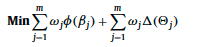

In [318]:
all_possible_patient_schedules

[{'patient': 'p1',
  'bed': 'b1',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b2',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b3',
  'possible_allocated_schedule': {1: {1200: 0,
    1300: 0,
    1400: 0,
    1500: 0,
    1700: 0,
    1800: 0,
    1900: 0,
    2000: 0},
   2: {1900: 0, 2000: 0, 2100: 0, 2200: 0},
   3: {900: 0, 1000: 0, 1100: 0},
   4: {2000: 0, 2100: 0, 2200: 0},
   6: {1300: 0, 1400: 0, 1500: 0}}},
 {'patient': 'p1',
  'bed': 'b4

Set some initial variables

In [319]:
patient_counter = 0
patient_schedules_in_list = []
patient_schedules_out_list = []

In [320]:
multi_appt_assigned_days = {}

#### 4ai. Reserve beds for patients on a first come first serve basis

In [321]:
patient_schedules_out_list, patient_schedules_in_list = reserve_patient_beds(all_possible_patient_schedules, patient_schedules_in_list, patient_schedules_out_list, bed_objects_list)

print("this is the patient_schedules_out_list", patient_schedules_out_list)
print("this is the patient_schedules_in_list", patient_schedules_in_list)

this is the patient_schedules_out_list [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b5', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0,

#### 4aii. Check the spacing between the times in terms of how far apart they are regardless if they are occupying another bed

In [322]:
patient_schedules_out_list, patient_schedules_in_list, multi_appt_assigned_days = check_time_spacing(patient_schedules_out_list, patient_schedules_in_list, bed_objects_list)

print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b5', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 20

#### 4aiii. Remove non-consecutive schedules

In [323]:
patient_schedules_in_list = remove_non_consecutive_schedules(patient_schedules_out_list, patient_schedules_in_list)

In [324]:
# Print the modified schedule list
for entry in patient_schedules_in_list:
    print(entry)

{'patient': 'p1', 'bed': 'b1', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b1', 'day': 3, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b1', 'day': 6, 'schedule': {1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 3, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b2', 'day': 6, 'schedule': {1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b3', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b3', 'day': 3, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b3', 'day': 6, 'schedule': {1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b4', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b4', 'day': 3, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b4', 'day': 6, 'schedule': {1300: 0, 140

#### 4aiv. Check that patient does not already occupy another bed!

In [325]:
patient_schedules_out_list, patient_schedules_in_list = remove_occupied_beds(patient_schedules_out_list, patient_schedules_in_list, bed_objects_list, multi_appt_assigned_days)

In [326]:
print("patient_schedule_out_list:", patient_schedules_out_list)
print("patient_schedule_in_list:", patient_schedules_in_list)

patient_schedule_out_list: [{'patient': 'p2', 'bed': 'b1', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b1', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b2', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b3', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0}}, {'patient': 'p2', 'bed': 'b4', 'day': 4, 'schedule': {1100: 0, 1200: 0, 1300: 0, 1400: 0, 1900: 0, 2000: 0, 2100: 0}}, {'patient': 'p2', 'bed': 'b5', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0, 20

In [327]:
for i in patient_schedules_in_list:
    print(i)

{'patient': 'p1', 'bed': 'b14', 'day': 3, 'schedule': {900: 0, 1000: 0, 1100: 0}}
{'patient': 'p1', 'bed': 'b15', 'day': 1, 'schedule': {1200: 0, 1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p1', 'bed': 'b15', 'day': 6, 'schedule': {1300: 0, 1400: 0, 1500: 0}}
{'patient': 'p2', 'bed': 'b10', 'day': 5, 'schedule': {1900: 0, 2000: 0, 2100: 0}}
{'patient': 'p2', 'bed': 'b11', 'day': 3, 'schedule': {1700: 0, 1800: 0, 1900: 0, 2000: 0}}
{'patient': 'p3', 'bed': 'b4', 'day': 4, 'schedule': {1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0}}
{'patient': 'p3', 'bed': 'b5', 'day': 2, 'schedule': {1600: 0, 1700: 0, 1800: 0, 1900: 0}}
{'patient': 'p4', 'bed': 'b7', 'day': 4, 'schedule': {1900: 0, 2000: 0, 2100: 0}}
{'patient': 'p6', 'bed': 'b2', 'day': 5, 'schedule': {900: 0, 1000: 0, 1100: 0, 1200: 0}}
{'patient': 'p7', 'bed': 'b4', 'day': 6, 'schedule': {1800: 0, 1900: 0, 2000: 0}}
{'patient': 'p8', 'bed': 'b13', 'day': 1, 'schedule': {800: 0, 900: 0, 1000: 0, 1100: 0}}
{'patient': 'p9', 'bed': 'b14', '

In [328]:
check_occupied_beds(patient_schedules_in_list, bed_objects_list)

THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
Bed b1 Day 4 Time Slot 1000 Assigned to p12
Bed b1 Day 4 Time Slot 1100 Assigned to p12
Bed b1 Day 4 Time Slot 1200 Assigned to p12
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
Bed b1 Day 6 Time Slot 900 Assigned to p17
Bed b1 Day 6 Time Slot 1000 Assigned to p17
Bed b1 Day 6 Time Slot 1100 Assigned to p17
Bed b1 Day 6 Time Slot 1200 Assigned to p17
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
THIS IS THE BED_ID b1
Bed b1 Day 4 Time Slot 1000 Occupied by p12
Bed b1 Day 4 Time Slot 1100 Occupied by p12
Bed b1 Day 

In [329]:
for bed in bed_objects_list:
    print(bed.bed_id)
    for day in bed.bed_schedule: 
        print(day, bed.bed_schedule[day])

b1
1 {800: 0, 900: 'p57', 1000: 'p57', 1100: 'p57', 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
2 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
3 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
4 {800: 0, 900: 0, 1000: 'p12', 1100: 'p12', 1200: 'p12', 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
5 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
6 {800: 0, 900: 'p17', 1000: 'p17', 1100: 'p17', 1200: 'p17', 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
b2
1 {800: 0, 900: 0, 1000: 0, 1100: 0, 1200: 0, 1300: 0, 1400: 0, 1500: 0, 1600: 0, 1700: 0, 1800: 0, 1900: 0, 2000: 0, 2100: 0, 2200: 0}
2 

## 5. FCFS Class

### 5a. Initialize the FCFS Schedule Object

In [330]:
patient_schedules_in = patient_schedules_in_list
patient_schedules_out = patient_schedules_out_list
objective = 0
contribution = 0
penalty = 0

In [331]:
new_final_FCFS_schedule = FCFS_confirmed_schedule(patient_schedules_in, patient_schedules_out, objective, contribution, penalty)

In [332]:
# TODO Create function from this
# Get the schedule of the patient and assign to the new final FCFS schedule
for obj in patient_objects_list:
    schedule_list = []
    for patient_sched in patient_schedules_in:
        if obj.patient_id == patient_sched['patient']:
            schedule_entry = {}
            schedule_entry['bed'] = patient_sched['bed']
            schedule_entry['day'] = patient_sched['day']
            schedule_entry['schedule'] = patient_sched['schedule']
            schedule_list.append(schedule_entry)
            obj.confirmed_schedule = schedule_list

### 5b. Calculate the Leftover appointment

Functions: count_leftover_appointments, count_penalty, and count_total_confirmed_hours also are in calculate values for the objective function

In [333]:
# calculate leftover appointments
for obj in patient_objects_list:
    obj.leftover = num_required_dialysis_sessions - obj.calculate_schedule_length()

### 5c. Objective Function and Constraints

Let **J = { 1 , . . . , m } be the set of $m$ patients** to be allocated to a **set of $n$ identical beds I = { 1 , . . . , n }** over a six-day working week, where each day is 14-hour long. Each patient j ∈ Jis prescribed a total of $t_j$ hours of dialysis per week (split into ηequally-long dialysis appointments, usually η= 3 ). 
$p_j$ = Each dialysis appointment of a patient j ∈ J, therefore, has a processing time $p_j$ which includes the pa- tient’s check-in time, put-on time on a dialysis machine (a technician puts the patient on a bed (or a chair), and connects them to the dialysis machine), dialysis time on the dialysis machine, and take-offtime (a technician takes thepatient offthebed, discon- nects them from the dialysis machine and cleans the bed).

**Main objective**: Therefore, our main objective is to maximize the number of appointments that are scheduled according to patients’ availability (with a minimum of $\delta$ slots deviation from their ideal time slots). Equivalently, we penalize the failure to assign any number of the required $\nu$ appointments for each patient (i.e., leftover ap-
pointments) as well as the total deviations in the patient’s weekly schedule.

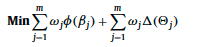

**Objective** : minimize the total leftover appointments penalty, which is calculated as the equation below where $w_j$ is a pre-specified weight computed based on the severity of the patient’s health condition

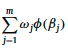

**Explanation of terms below:**

$\theta_j$ $\subseteq$ $S$ be the set of all time slots that patient j's dialysis appointments are allocated to

$\beta_j$ = total number of leftover appointments in schedule $\theta_j$ of patient $j$

 is total number of leftover appointments in schedule $\theta_j$ of patient j 

$\phi$ $(\beta_j)$ = penalty associated with $\theta$ with $\phi$(0) = 0 and $\phi$(1) $\geq \eta * m * \delta$ , and we assume $\phi$(3) $\gg$ $\phi$(2) $\gg$ $\phi$(1) where the highest priority is to minimize the number of patients with 3 leftover appointments.

$\eta$ = number of required dialysis sessions of patients,
$m$ = number of patients,
$\delta$ = allowed deviation limit from patients' target slots

Each patient j ∈ J is prescribed a total of $t_j$ hours of dialysis per week (split into $\eta$ equally-long dialysis appointments, usually $\eta$ = 3 ) based on page 37 of Reihnahe et al.

calculate_value.py contains various functions used for calculating the objective function

In [334]:
obj_function = 0
total_confirmed_timeslots = 0
total_count_one = 0
total_count_two = 0
total_count_three = 0
total_count_zero = 0
total_count_dialysis_hours = 0

for obj in patient_objects_list:
    obj_function_inc, num_confirmed_timeslots, count_one, count_two, count_three, count_zero, confirmed_total_dialysis_hours =  calculate_objective_function(obj.patient_id, obj.confirmed_schedule, obj.weight, obj.leftover, obj.prescribed_total_dialysis_hours, num_required_dialysis_sessions, num_patients, max_allowed_deviation)
    obj_function += obj_function_inc
    total_confirmed_timeslots += num_confirmed_timeslots
    total_count_one += count_one
    total_count_two += count_two
    total_count_three += count_three
    total_count_zero += count_zero
    total_count_dialysis_hours += confirmed_total_dialysis_hours

In [335]:
obj_function

86375919.59999998

In [336]:
total_confirmed_timeslots

64

In [337]:
total_count_one

31

In [338]:
total_count_two

15

In [339]:
total_count_three

1

In [340]:
total_count_zero

13

In [341]:
total_count_dialysis_hours

224

In [342]:
prescribed_total_dialysis_hours_all_patients = sum(prescribed_dialysis_hours_list)
prescribed_total_dialysis_hours_all_patients

708

## 6. Getting the results of FCFS

Dialysis treatment times are 4 hours to comply with the average reported length of hemodialysis treatment , but it is usually between 3 to 5 hours. So lets find a time when both patients and beds are free at the same time and store it in a dictionary

### 6a. RUN ONLY IF RUNNING FOR THE FIRST TIME, OTHERWISE COMMENT IT OUT

In [343]:
initial_rows = [
    "Number of beds",
    "Number of patients",
    "Max allowed deivation",
    "Objective function",
    "Total confirmed slots",
    "Total confirmed hours",
    "Percentage leftover slots out of prescribed",
    "Percentage confirmed hours out of prescribed",
    "Count 0",
    "Count 1",
    "Count 2",
    "Count 3"
]

In [344]:
# FCFS_df = []

# FCFS_df = pd.DataFrame({str(0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},index = [initial_rows])

### 6b. RUN THE FOLLOWING CODE FREELY TO POPULATE THE DATAFRAME

In [345]:
title_rows_bed = str(num_beds) + '-' + str(num_patients) + '-' + str(max_allowed_deviation)

In [346]:
percentage_slots_leftover = 1 - (total_confirmed_timeslots / (num_patients * num_required_dialysis_sessions))
percentage_hours = (total_count_dialysis_hours / prescribed_total_dialysis_hours_all_patients)

In [347]:
# If the number of bedds equals to zero then this the dataframe still has the initial values
if FCFS_df.iloc[:,0]['Number of beds'] == 0:
    FCFS_df = FCFS_df.rename(columns={'0':title_rows_bed})
    
    FCFS_df.iloc[0, 0] = num_beds
    FCFS_df.iloc[1, 0] = num_patients
    FCFS_df.iloc[2, 0] = max_allowed_deviation
    FCFS_df.iloc[3, 0] = obj_function
    FCFS_df.iloc[4, 0] = total_confirmed_timeslots
    FCFS_df.iloc[5, 0] = total_count_dialysis_hours
    FCFS_df.iloc[6, 0] = percentage_slots_leftover
    FCFS_df.iloc[7, 0] = percentage_hours
    FCFS_df.iloc[8, 0] = total_count_zero
    FCFS_df.iloc[9, 0] = total_count_one
    FCFS_df.iloc[10, 0] = total_count_two
    FCFS_df.iloc[11, 0] = total_count_three
else:
    FCFS_df[title_rows_bed] = [num_beds, num_patients, max_allowed_deviation, obj_function, total_confirmed_timeslots, total_count_dialysis_hours, 
                               percentage_slots_leftover, percentage_hours, total_count_zero, total_count_one, total_count_two, total_count_three ]


In [348]:
FCFS_df[title_rows_bed] = [num_beds, num_patients, max_allowed_deviation, obj_function, total_confirmed_timeslots, total_count_dialysis_hours, 
                               percentage_slots_leftover, percentage_hours, total_count_zero, total_count_one, total_count_two, total_count_three ]


In [349]:
FCFS_df

10-40-1       15-60-1
Number of beds                                1.000000e+01  1.500000e+01
Number of patients                            4.000000e+01  6.000000e+01
Max allowed deivation                         1.000000e+00  1.000000e+00
Objective function                            1.960969e+07  8.637592e+07
Total confirmed slots                         4.800000e+01  6.400000e+01
Total confirmed hours                         1.690000e+02  2.240000e+02
Percentage leftover slots out of prescribed   6.000000e-01  6.444444e-01
Percentage confirmed hours out of prescribed  3.313725e-01  3.163842e-01
Count 0                                       9.000000e+00  1.300000e+01
Count 1                                       1.500000e+01  3.100000e+01
Count 2                                       1.500000e+01  1.500000e+01
Count 3                                       1.000000e+00  1.000000e+00

### 6c. After you run the file to include all combinations of (n,m,δ)

#### 6ci. Save the FCFS_df dataframe with all the results of the FCFS approaach to a CSV file

In [350]:
# Define the date to add to the end of the CSV file
now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

file_name = 'results_FCFS'+dt_string+'.csv'

FCFS_df.to_csv('results/'+file_name, sep=',', encoding='utf-8')

### 6d. Create some graphs

#### 6di. Define values to create the catplot

In [351]:
obj_function_values = FCFS_df.iloc[3].tolist()
obj_function_values

[19609690.599999998, 86375919.59999998]

In [352]:
combi_patient_bed_deviation = list(FCFS_df.columns)

In [353]:
bars_count = ['count 0', 'count 1', 'count 2', 'count 3']
bars_graph = []

for i in range(len(combi_patient_bed_deviation)):
    bars_graph.extend(bars_count)

In [354]:
combi_graph = []
for combi in combi_patient_bed_deviation:
    for bars in range(len(bars_count)):
        combi_graph.append(combi)
        
combi_graph.sort()

In [355]:
count_values = []

for column in range(0, len(FCFS_df.columns)):
    for row in range(8, len(FCFS_df)):
        print(FCFS_df.iloc[row, column])
        count_values.append(FCFS_df.iloc[row, column])


9.0
15.0
15.0
1.0
13.0
31.0
15.0
1.0


#### 6dii. Draw the Catplot to show the distributions of the number of appointments across different combinations of (n,m,δ)

In [356]:
patient_bed_ratio = int(num_patients / num_beds)

AttributeError: 'function' object has no attribute 'remove'

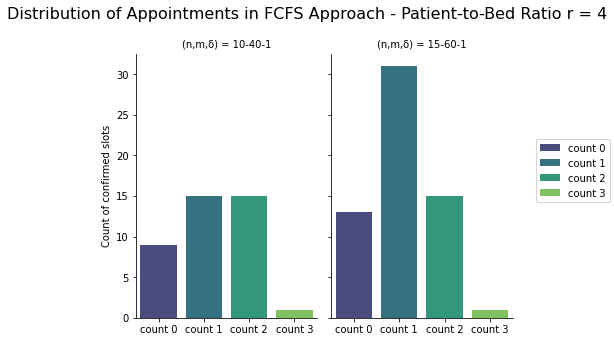

In [357]:
df = pd.DataFrame({'(n,m,δ)': combi_graph,
                   'bar': bars_graph,
                   'value': count_values})
g = sns.catplot(kind='bar', data=df, col='(n,m,δ)', x='bar', y='value',
                hue='bar', palette='viridis', dodge=False, sharex=False, aspect=0.6, legend=False)


# Set overall title for the entire catplot
plt.subplots_adjust(top=0.85)  # Adjust the top space for the title
g.fig.suptitle("Distribution of Appointments in FCFS Approach - Patient-to-Bed Ratio r = " + str(patient_bed_ratio), fontsize=16)  # Set the main title


# Change y-axis title*
g.set_axis_labels("", "Count of confirmed slots")  # Replace with your desired labels

# Get the current axes
axes = g.axes.flatten()

# Create a single legend outside the loop
handles, labels = axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='center right')  # Adjust the loc parameter

g.fig.legend.remove

# Set the font size of xticks
plt.xticks(fontsize=25)
plt.tight_layout()
plt.show()

#### 6dii. Draw a line graph to show the patterns for the objective function

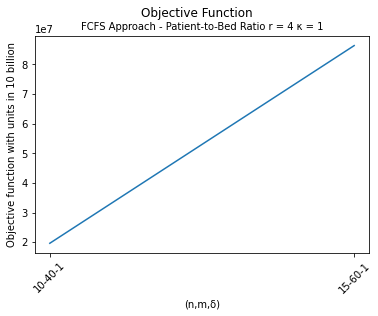

In [358]:
# Create the line chart
plt.plot(obj_function_values)

# Set x-axis labels
plt.xticks(range(len(combi_patient_bed_deviation)), combi_patient_bed_deviation, rotation=45)  # Set x-axis labels with positions and labels

# Set y-axis label
plt.ylabel("Objective function with units in 10 billion")
plt.xlabel("(n,m,δ)")

# Set title
plt.suptitle("Objective Function", fontsize = 12)
plt.title("FCFS Approach - Patient-to-Bed Ratio r = " + str(patient_bed_ratio) + " κ = 1", fontsize = 10)

# Show the plot
plt.show()